## Load Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error \
    , accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

# Impute missing numeric values with MICE.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Utility Functions

In [81]:
def get_indicators(df, drop_cols=[]):
    """
    Encode categorical columns.
    """
    df = df.copy()
    if len(drop_cols) > 0:
        intersect = [col for col in df.columns if col in drop_cols]
        df.drop(intersect, 1, inplace=True)
        
    df = pd.get_dummies(data=df)
    cols = df.columns
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in cols]
    return df


def get_vifs(df):
    cols = df.columns.to_list()
    X = df.values
    vifs = [(cols[i], variance_inflation_factor(X, i)) for i in range(len(cols))]
    return pd.DataFrame(columns=["Feature", "VIF"], data=vifs)


def mmp(x, prob, actual, title):
    """
    Marginal Model Plots for Binary Model Fit Validation
    Based on methodology established by Weisberg, 2005.
    """
    yhat = lowess(endog=prob, exog=x, frac=.2, it=0)
    x1 = yhat[:,0]
    y1 = yhat[:,1]

    Y = lowess(endog=actual, exog=x, frac=.2, it=0)
    x2 = Y[:,0]
    y2 = Y[:,1]
    
    fig1, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(x1, y1, color='blue', alpha=0.7)
    ax2.plot(x2, y2, color='red', alpha=0.7)
    ax1.set_title(title)
    ax1.set_ylabel('Actual + Prob')
    ax1.set_xlabel('X')
    plt.show()


def get_elasticnet(X, y, column_names, max_iter=10000):
    """
    Select significant variables according to Elastic Net.
    @param X <Pandas Dataframe>
    @param y <list>
    @columns <list>
    @max_iter <int>
    @returns <list>
    """ 
    def get_mse(alpha):
        model = ElasticNet(alpha=a, max_iter=max_iter).fit(X, y)   
        score = model.score(X, y)
        pred_y = model.predict(X)
        return mean_squared_error(y, pred_y)
        
    lowest_mse = 1.0
    best_alpha = 0.0
    alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
    
    for a in alphas:
        mse = get_mse(a)
        if mse < lowest_mse:
            lowest_mse = mse
            best_alpha = a
        
    clf = ElasticNet(alpha=best_alpha, max_iter=max_iter)
    sfm = SelectFromModel(clf)
    sfm.fit(X, y)
    feature_indices = sfm.get_support()
    significant_features = []
    for c, b in zip(column_names, feature_indices):
        if b:
            significant_features.append(c)

    return significant_features


def get_balanced_accuracy(tpr, fpr):
    """
    Return average of Sensitivity and Specificity.
    """
    return (tpr + (1-fpr)) / 2


def get_tpr_fpr(cm):
    """
    Sensitivity: TruePos / (True Pos + False Neg) 
    Specificity: True Neg / (False Pos + True Neg)
    TN | FP
    -------
    FN | TP
    @param 2D array <list<list>>
    @returns <list<float>>
    """
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])

    tpr = tp / (tp + fn)
    fpr = 1-(tn / (fp + tn))

    return [tpr, fpr]


def get_best_cutoff(actual, prob):  
    """
    Get the best cutoff according to Balanced Accuracy
    'Brute-force' technique - try all cutoffs from 0.01 to 0.99 in increments of 0.01

    @param actual <list<float>>
    @param prob <list<tuple<float, float>>>
    @returns <list<float>>
    """
    best_tpr = 0.0; best_fpr = 0.0; best_cutoff = 0.0; best_ba = 0.0; 
    cutoff = 0.0
    cm = [[0,0],[0,0]]
    while cutoff < 1.0:
        pred = list(map(lambda p: 1 if p >= cutoff else 0, prob))
        _cm = confusion_matrix(actual, pred)
        _tpr, _fpr = get_tpr_fpr(_cm)

        if(_tpr < 1.0):    
            ba = get_balanced_accuracy(tpr=_tpr, fpr=_fpr)

            if(ba > best_ba):
                best_ba = ba
                best_cutoff = cutoff
                best_tpr = _tpr
                best_fpr = _fpr
                cm = _cm

        cutoff += 0.01

    tn = cm[0][0]; fp = cm[0][1]; fn = cm[1][0]; tp = cm[1][1];
    return [best_tpr, best_fpr, best_cutoff, tn, fp, fn, tp]


def get_predict_frame(actual, prob, model_name='Logit'):
    """
    Compute predicted based on estimated probabilities and best threshold. 
    Output predictions and confusion matrix.
    """
    # calculate TPR, FPR, best probability threshold
    tpr, fpr, cutoff, tn, fp, fn, tp = get_best_cutoff(actual, prob)
    accuracy = get_balanced_accuracy(tpr, fpr)
    auc = roc_auc_score(actual, prob)
    
    #print("Optimal prob. threshold is %0.3f: " % cutoff)
    yhat = list(map(lambda p: 1 if p >= cutoff else 0, prob))
    stats = pd.DataFrame(columns=['Model', 'TP', 'FP', 'TN', 'FN', 'Sensitivity', 'Specificity', 'Cutoff', 'Accuracy', 'AUC'],
                data=[[model_name, tp, fp, tn, fn, tpr, (1-fpr), cutoff, accuracy, auc]])

    print("Sensitivity: {0:.3f}%, Specificity: {1:.3f}%, Threshold: {2:.3f}".format(tpr*100, (1-fpr)*100, cutoff))
    return yhat, stats


def plot_roc(actual, prob, title='ROC Curve'):
    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(actual, prob)

    # plot ROC curve
    fig = plt.figure(figsize=(10, 10))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title(title)
    plt.show()

## Load Training Data

In [45]:
TARGET_NAME = "IsBadBuy"
ID_COL = "RefId"

def get_data(path: str):
    schema = {
        "RefId": "object",
        "IsBadBuy": "uint8",
        "PurchDate": "object",
        "Auction": "object",
        "VehYear": "object",
        "VehicleAge": "int32",
        "Make": "object",
        "Model": "object",
        "Trim": "object",
        "SubModel": "object",
        "Color": "object",
        "Transmission": "object",
        "WheelTypeID": "object",
        "WheelType": "object",
        "VehOdo": "int32",
        "Nationality": "object",
        "Size": "object",
        "TopThreeAmericanName": "object",
        "MMRAcquisitionAuctionAveragePrice": "float32",
        "MMRAcquisitionAuctionCleanPrice": "float32",
        "MMRAcquisitionRetailAveragePrice": "float32",
        "MMRAcquisitonRetailCleanPrice": "float32",
        "MMRCurrentAuctionAveragePrice": "float32",
        "MMRCurrentAuctionCleanPrice": "float32",
        "MMRCurrentRetailAveragePrice": "float32",
        "MMRCurrentRetailCleanPrice": "float32",
        "PRIMEUNIT": "object",
        "AUCGUART": "object",
        "BYRNO": "object",
        "VNZIP1": "object",
        "VNST": "object",
        "VehBCost": "float32",
        "IsOnlineSale": "uint8",
        "WarrantyCost": "float32"
    }

    df = pd.read_csv(path, dtype=schema, date_parser=["PurchDate"])
    df.drop(["PurchDate", "VehYear"], axis=1, inplace=True)
    return df
    

In [60]:
df_train = get_data("./data/training.csv")
df_val = df_train.sample(frac=0.2, random_state=123)
df_train.drop(df_val.index, inplace=True)
df_test = get_data("./data/test.csv")
display(df_train)

,RefId,IsBadBuy,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,ADESA,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113.0
2,3,0,ADESA,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389.0
3,4,0,ADESA,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630.0
4,5,0,ADESA,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020.0
5,6,0,ADESA,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,AUTO,...,8149.0,9451.0,NaN,NaN,19638,33619,FL,5600.0,0,594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72977,73009,0,ADESA,3,KIA,SORENTO 2WD,EX,4D SPORT UTILITY EX,GOLD,AUTO,...,12148.0,14204.0,NaN,NaN,18111,30212,GA,7900.0,0,1508.0
72978,73010,1,ADESA,8,MERCURY,SABLE,GS,4D SEDAN GS,BLACK,AUTO,...,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993.0
72979,73011,0,ADESA,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,SILVER,AUTO,...,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038.0
72980,73012,0,ADESA,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,SILVER,AUTO,...,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893.0


### Imputation

In [61]:
def impute_missing_nums(df, cols):
    for col in cols:
        if col in df.columns:
            X = df[col].values
            median = np.median([x for x in X if x != np.NaN and x > 0])
            X = np.array(list(map(lambda x: (median if x==np.NaN or x==0 or pd.isna(x) else x), X)))
            df[col] = X
    return df
        

def impute_missing_cats(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].fillna(value=df[col].mode()[0])
    return df
        

def get_missing(df):
    """
    Check for missing data
    Remove where missing % is greater than 5%. Impute missing values <= 5%.
    """
    df_types = df.dtypes.to_frame()
    df_types.reset_index(drop=True, inplace=True)
    df_types.columns = ["Type"]

    ln = df.count()
    df_missing = (df.isnull().sum() / ln).to_frame()
    df_missing["Feature"] = df_missing.index
    df_missing.reset_index(drop=True, inplace=True)
    df_missing.columns = ["Missing", "Feature"]
    df_missing = pd.concat([df_missing, df_types], 1)
    df_missing = df_missing.sort_values(by="Missing", ascending=False)
    return df_missing


if __name__ == '__main__':
    df_missing = get_missing(df_train)
    display(df_missing)

,Missing,Feature,Type
24,20.047585,PRIMEUNIT,object
25,20.047585,AUCGUART,object
11,0.045314,WheelType,object
10,0.045276,WheelTypeID,object
6,0.033125,Trim,object
23,0.004128,MMRCurrentRetailCleanPrice,float32
22,0.004128,MMRCurrentRetailAveragePrice,float32
21,0.004128,MMRCurrentAuctionCleanPrice,float32
20,0.004128,MMRCurrentAuctionAveragePrice,float32
19,0.000188,MMRAcquisitonRetailCleanPrice,float32


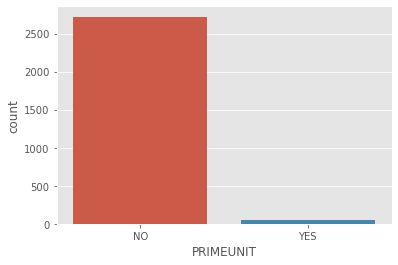

In [62]:
prime_unit = sb.countplot(x=df_train["PRIMEUNIT"])
plt.show()

In [63]:
df_train['IsPrime'] = np.array(list(map(lambda col: 1 if col == 'YES' else 0, df_train["PRIMEUNIT"].values)))
df_val['IsPrime'] = np.array(list(map(lambda col: 1 if col == 'YES' else 0, df_val["PRIMEUNIT"].values)))
df_test['IsPrime'] = np.array(list(map(lambda col: 1 if col == 'YES' else 0, df_test["PRIMEUNIT"].values)))

In [64]:
df_test

,RefId,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,...,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsPrime
0,73015,ADESA,4,PONTIAC,GRAND PRIX,Bas,4D SEDAN,SILVER,AUTO,1,...,9752.0,NaN,NaN,18881,30212,GA,6500.0,0,2152.0,0
1,73016,ADESA,4,CHEVROLET,MALIBU V6,LS,4D SEDAN LS,SILVER,AUTO,1,...,9296.0,NaN,NaN,18111,30212,GA,6300.0,0,1118.0,0
2,73017,ADESA,3,DODGE,DURANGO 2WD V8,Adv,4D SUV 4.7L ADVENTURER,SILVER,AUTO,1,...,16512.0,NaN,NaN,18111,30212,GA,9700.0,0,1215.0,0
3,73018,ADESA,7,SATURN,L SERIES,L20,4D SEDAN L200,GOLD,AUTO,1,...,6398.0,NaN,NaN,18881,30212,GA,4150.0,0,1933.0,0
4,73019,ADESA,2,HYUNDAI,ACCENT,GS,2D COUPE GS,BLUE,AUTO,NaN,...,7350.0,NaN,NaN,18111,30212,GA,4100.0,0,920.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48702,121742,MANHEIM,5,FORD,FIVE HUNDRED,SEL,4D SEDAN SEL,BLACK,AUTO,1,...,11395.0,NaN,NaN,20928,33411,FL,7955.0,0,1633.0,0
48703,121743,MANHEIM,3,TOYOTA,COROLLA,CE,4D SEDAN CE,GREEN,AUTO,2,...,11565.0,NaN,NaN,20928,33411,FL,7035.0,0,594.0,0
48704,121744,MANHEIM,4,KIA,SPECTRA,EX,4D SEDAN EX,BLACK,AUTO,2,...,9490.0,NO,GREEN,20928,33411,FL,6335.0,0,594.0,0
48705,121745,MANHEIM,5,MAZDA,MAZDA3,s,4D SEDAN GT,SILVER,AUTO,1,...,9937.0,NO,GREEN,20928,33411,FL,8055.0,0,1038.0,0


In [65]:
# Drop columns where missing > 5% of data.
drop_cols = df_missing.where(df_missing["Missing"] > 0.05)["Feature"].dropna().to_list()
drop_cols

['PRIMEUNIT', 'AUCGUART']

In [66]:
cat_cols = df_missing.where(df_missing["Type"] == "object").dropna()["Feature"].to_list()
cat_cols = [col for col in cat_cols if col not in drop_cols]
cat_cols

['WheelType',
 'WheelTypeID',
 'Trim',
 'Transmission',
 'Color',
 'SubModel',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'VNZIP1',
 'VNST',
 'BYRNO',
 'RefId',
 'Model',
 'Make',
 'Auction']

### Impute Missing Cat Values

In [67]:
df_train = impute_missing_cats(df_train, cat_cols)
df_train[cat_cols].isnull().sum()

WheelType               0
WheelTypeID             0
Trim                    0
Transmission            0
Color                   0
SubModel                0
Nationality             0
Size                    0
TopThreeAmericanName    0
VNZIP1                  0
VNST                    0
BYRNO                   0
RefId                   0
Model                   0
Make                    0
Auction                 0
dtype: int64

In [68]:
numeric_cols = df_missing.where(df_missing["Type"] != "object").dropna()["Feature"].to_list()
if TARGET_NAME in numeric_cols:
    numeric_cols.remove(TARGET_NAME)
    
numeric_cols

['MMRCurrentRetailCleanPrice',
 'MMRCurrentRetailAveragePrice',
 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRAcquisitonRetailCleanPrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionAuctionAveragePrice',
 'VehBCost',
 'IsOnlineSale',
 'VehOdo',
 'VehicleAge',
 'WarrantyCost']

### Impute Missing Numeric Values

In [69]:
df_train = impute_missing_nums(df_train, numeric_cols)
df_train[numeric_cols].isnull().sum()

MMRCurrentRetailCleanPrice           0
MMRCurrentRetailAveragePrice         0
MMRCurrentAuctionCleanPrice          0
MMRCurrentAuctionAveragePrice        0
MMRAcquisitonRetailCleanPrice        0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionAuctionAveragePrice    0
VehBCost                             0
IsOnlineSale                         0
VehOdo                               0
VehicleAge                           0
WarrantyCost                         0
dtype: int64

## Univariate and Multivariate Exploration

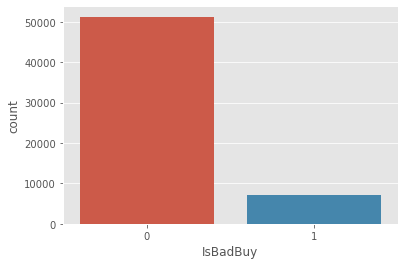

In [70]:
isbadbuy = sb.countplot(x=TARGET_NAME, data=df_train)

### Outlier Analysis

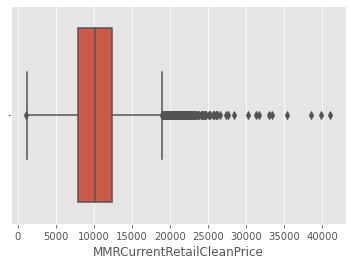

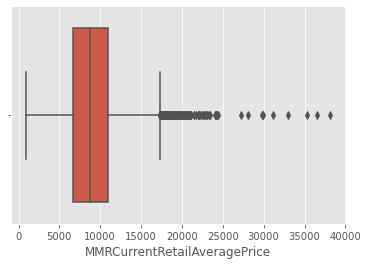

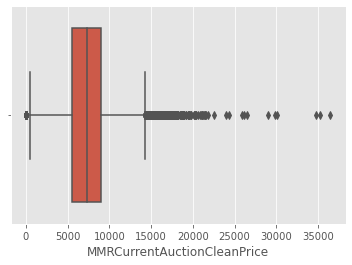

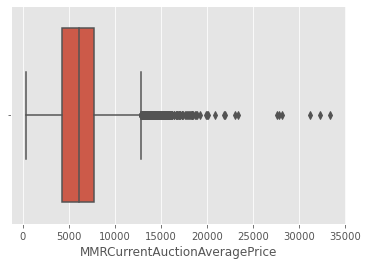

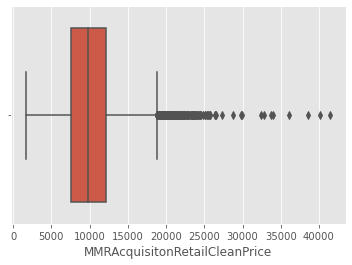

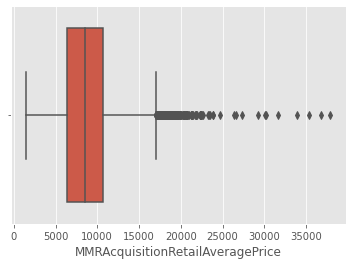

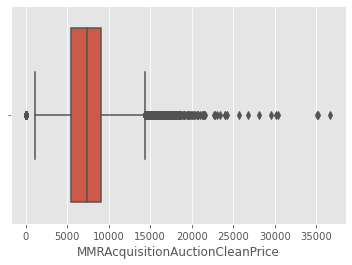

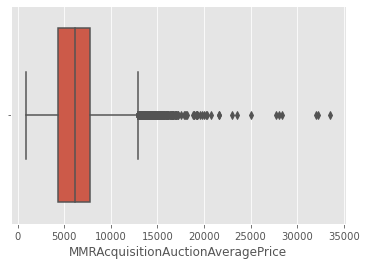

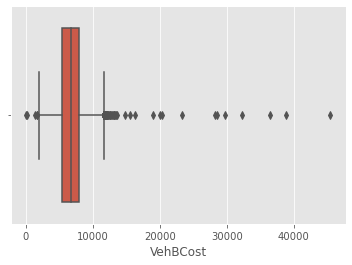

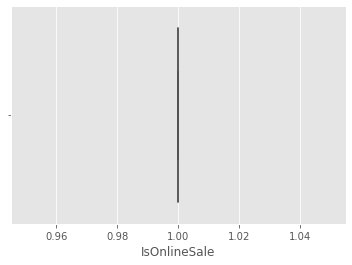

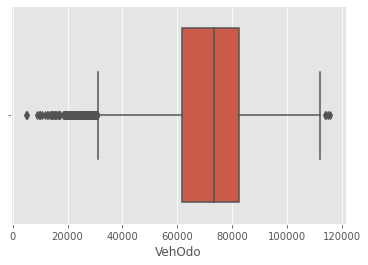

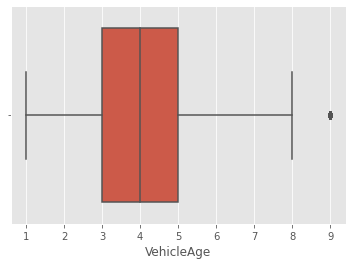

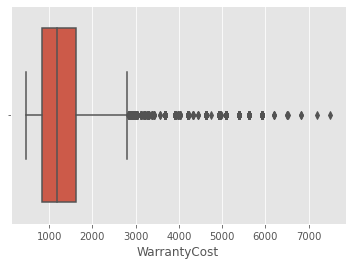

In [15]:
if __name__ == '__main__':
    for col in numeric_cols:
        p = sb.boxplot(x=df_train[col])
        plt.show()

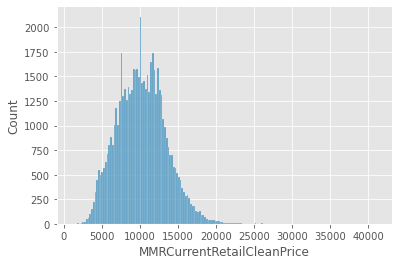

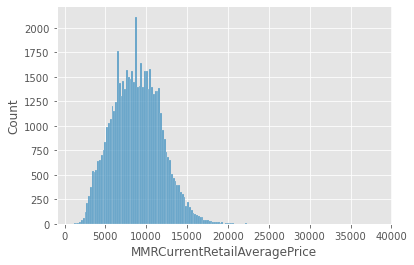

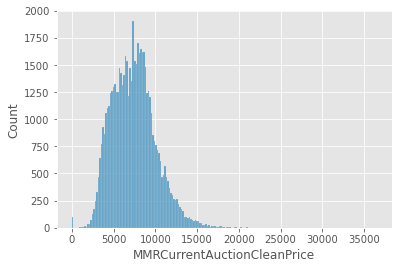

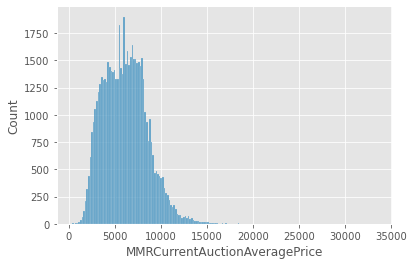

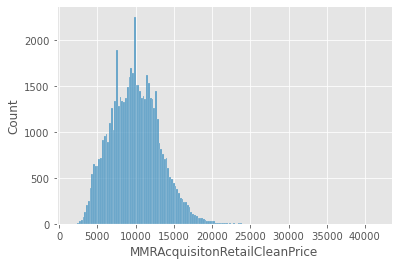

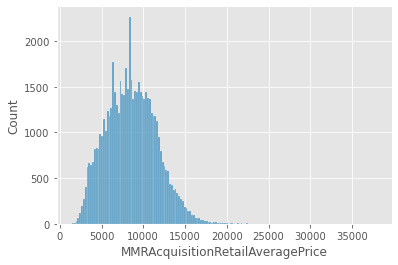

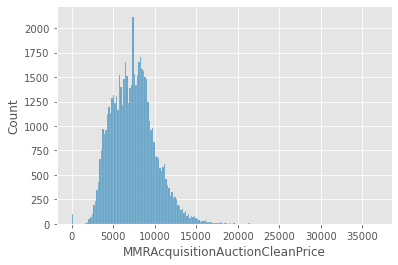

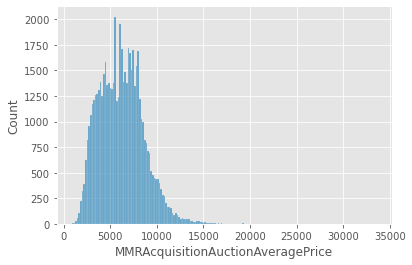

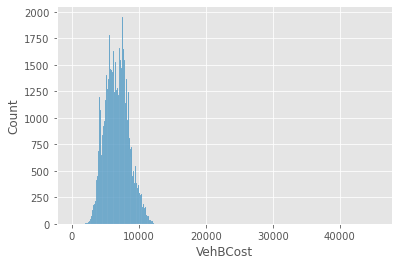

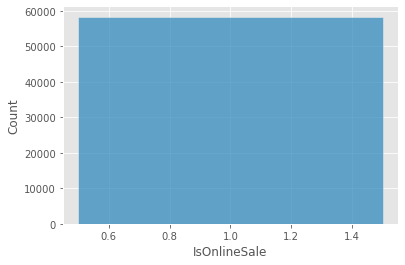

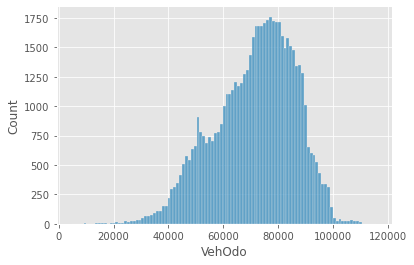

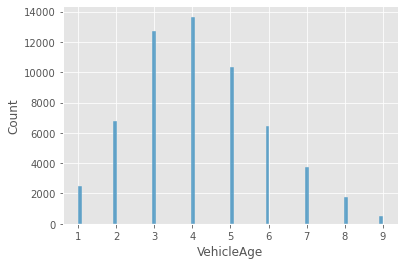

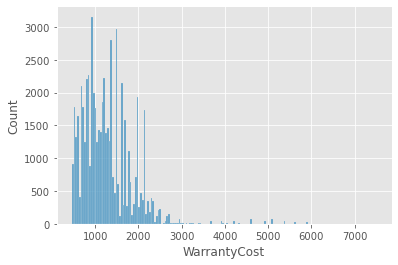

In [16]:
for col in numeric_cols:
    p = sb.histplot(x = df_train[col])
    plt.show()

### Scatterplot Matrix to identify multicolinearity.

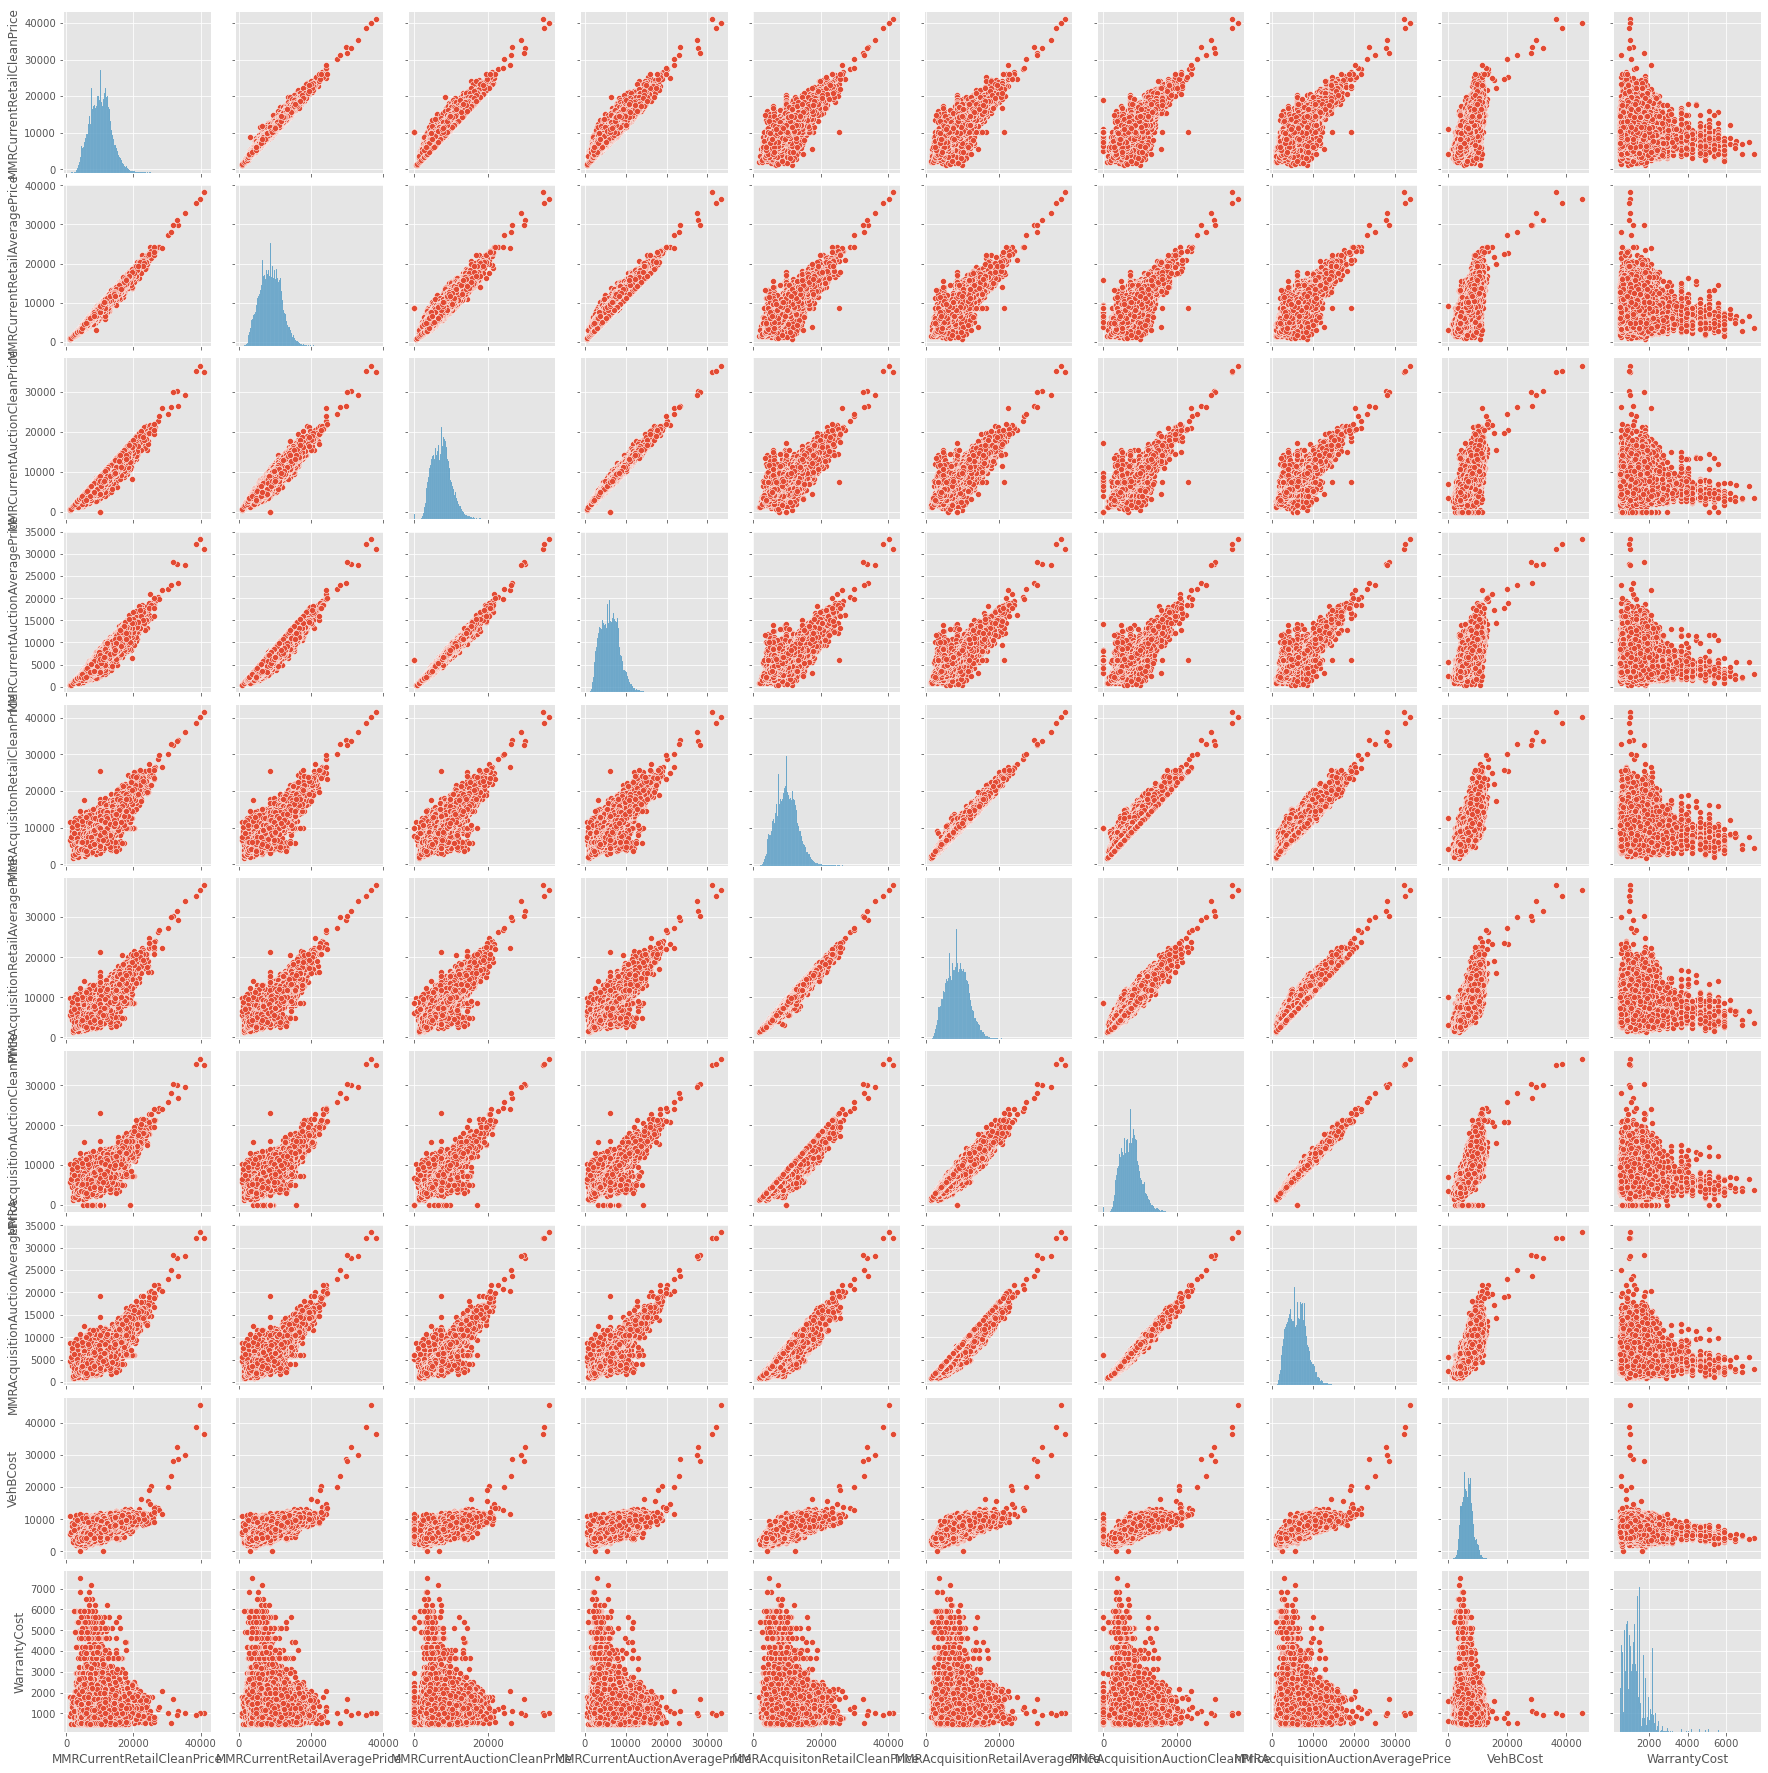

In [17]:
# Look for high multicolinearity between numeric columns.
if __name__ == '__main__':
    scatter = sb.pairplot(df_train[numeric_cols].drop(["IsOnlineSale", "VehicleAge", "VehOdo"], 1))
    scatter.savefig("./output/scatterplot.png")

### Heatmap to identify multicolinearity.

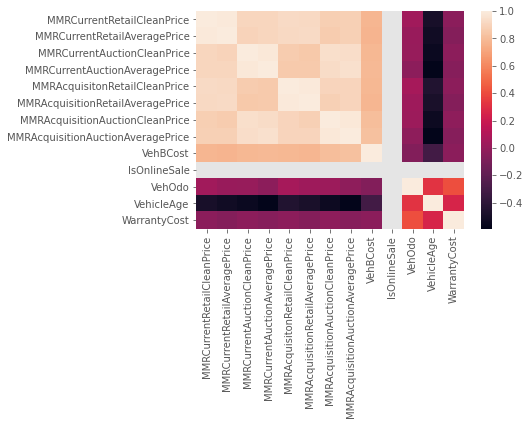

In [71]:
# Look for high multicolinearity between numeric columns.
correlations = df_train[numeric_cols].corr()
heatmap = sb.heatmap(correlations)
plt.show()

### Remove redundant predictors with Variance Inflation Factors >= 10.

In [72]:
num_x = df_train[numeric_cols].copy()
df_vif = get_vifs( num_x )
df_vif

,Feature,VIF
0,MMRCurrentRetailCleanPrice,104.640587
1,MMRCurrentRetailAveragePrice,109.921907
2,MMRCurrentAuctionCleanPrice,132.584673
3,MMRCurrentAuctionAveragePrice,140.495094
4,MMRAcquisitonRetailCleanPrice,109.505223
5,MMRAcquisitionRetailAveragePrice,109.935367
6,MMRAcquisitionAuctionCleanPrice,127.331087
7,MMRAcquisitionAuctionAveragePrice,139.175693
8,VehBCost,4.003925
9,IsOnlineSale,48.499705


In [73]:
# Select set of features all with VIFs < 10.
if False:
    temp_df = num_x.drop(
        [
         "MMRCurrentRetailAveragePrice"
         , "MMRCurrentAuctionAveragePrice"
         #, "MMRAcquisitionAuctionAveragePrice"
         , "MMRAcquisitionRetailAveragePrice"
         , "MMRCurrentAuctionCleanPrice"
         , "MMRAcquisitionAuctionCleanPrice"
         , "MMRAcquisitonRetailCleanPrice"
         , "MMRCurrentRetailCleanPrice"
         , "VehBCost"
         #, "VehOdo"
         #, "IsPrime"
         , "VehicleAge"
         , "WarrantyCost"
         , "IsOnlineSale"
        ], 1)

    df_vif = get_vifs(temp_df)
    df_vif

## Transform Data

In [74]:
numeric_cols = df_vif.Feature.values
numeric_cols = numeric_cols.tolist()
numeric_cols

['MMRCurrentRetailCleanPrice',
 'MMRCurrentRetailAveragePrice',
 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRAcquisitonRetailCleanPrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionAuctionAveragePrice',
 'VehBCost',
 'IsOnlineSale',
 'VehOdo',
 'VehicleAge',
 'WarrantyCost']

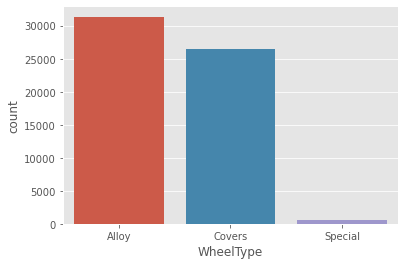

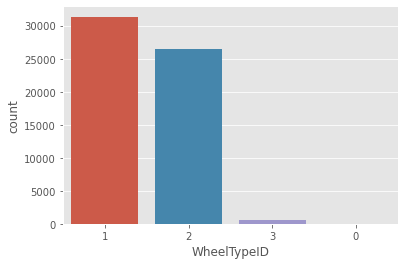

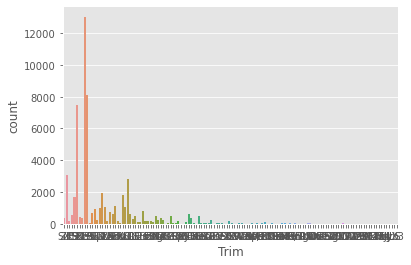

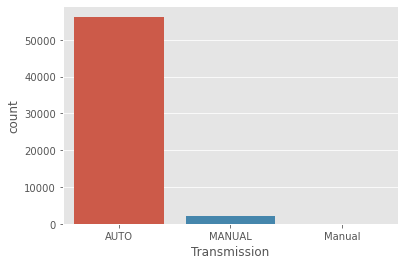

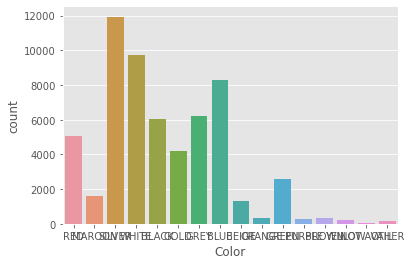

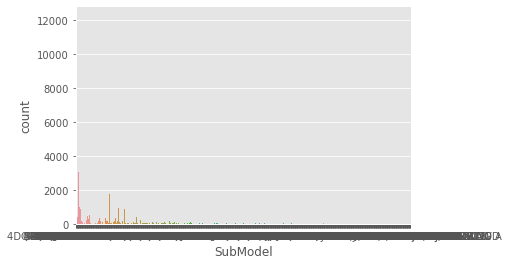

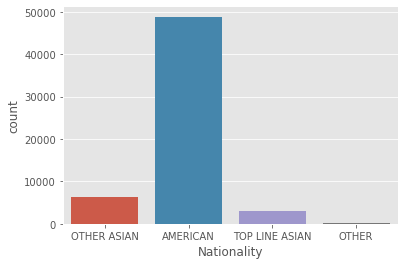

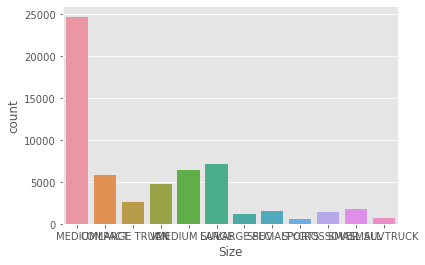

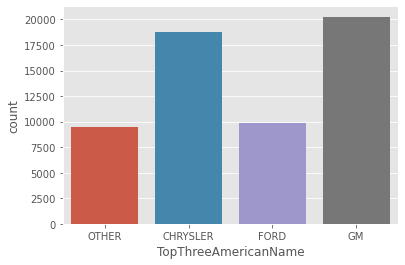

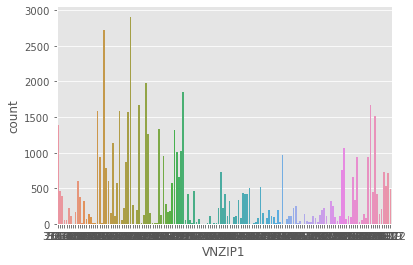

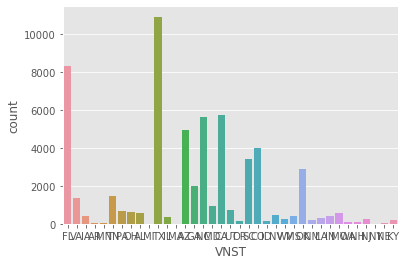

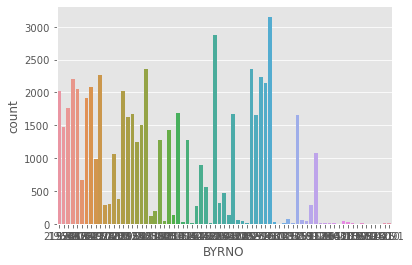

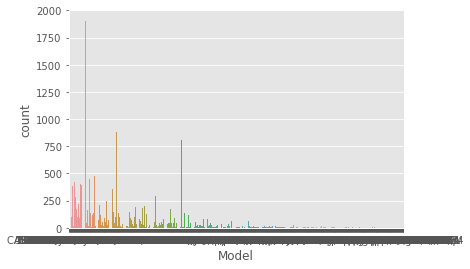

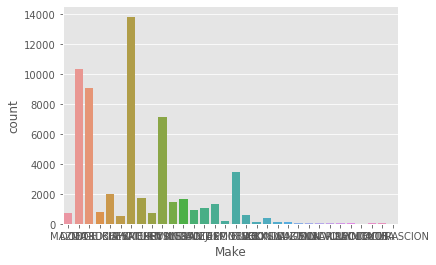

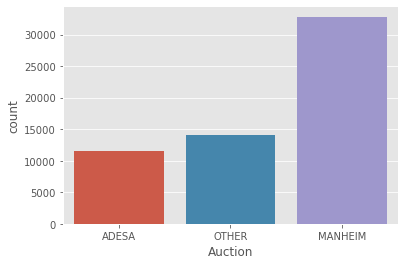

In [75]:
if __name__ == '__main__':
    for col in cat_cols:
        if col in df_train.columns and col != ID_COL:
            ct = sb.countplot(x=df_train[col])
            plt.show()

### Remove categorical variables with too many levels.

In [76]:
noisy_cols = ["Model", "VNST", "VNZIP1", "BYRNO", "SubModel", "Color", "Trim", "WheelTypeID"]

for col in noisy_cols:
    if(col in cat_cols):
        cat_cols.remove(col)

if ID_COL in cat_cols:
    cat_cols.remove(ID_COL)
    
cat_cols

['WheelType',
 'Transmission',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'Make',
 'Auction']

In [77]:
keep_cols = np.concatenate([np.array(cat_cols), np.array(numeric_cols)], 0)

if ID_COL in keep_cols:
    keep_cols.tolist().remove(ID_COL)
    
keep_cols

array(['WheelType', 'Transmission', 'Nationality', 'Size',
       'TopThreeAmericanName', 'Make', 'Auction',
       'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRAcquisitonRetailCleanPrice',
       'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionAuctionAveragePrice', 'VehBCost', 'IsOnlineSale',
       'VehOdo', 'VehicleAge', 'WarrantyCost'], dtype='<U33')

In [78]:
df_train = get_data("./data/training.csv")

df_val = df_train.sample(frac=0.2, random_state=123)
val_y = df_val[TARGET_NAME].values

df_train.drop(df_val.index, inplace=True)
train_y = df_train[TARGET_NAME].values

df_test = get_data("./data/test.csv")[keep_cols]

df_train = df_train[keep_cols].copy()
df_val = df_val[keep_cols].copy()

display(df_train)

,WheelType,Transmission,Nationality,Size,TopThreeAmericanName,Make,Auction,MMRCurrentRetailCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentAuctionAveragePrice,MMRAcquisitonRetailCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionAuctionAveragePrice,VehBCost,IsOnlineSale,VehOdo,VehicleAge,WarrantyCost
0,Alloy,AUTO,OTHER ASIAN,MEDIUM,OTHER,MAZDA,ADESA,12409.0,11597.0,8552.0,7451.0,13600.0,11636.0,9829.0,8155.0,7100.0,0,89046,3,1113.0
2,Covers,AUTO,AMERICAN,MEDIUM,CHRYSLER,DODGE,ADESA,8702.0,7146.0,5557.0,4035.0,8457.0,6943.0,4760.0,3202.0,4900.0,0,73807,4,1389.0
3,Alloy,AUTO,AMERICAN,COMPACT,CHRYSLER,DODGE,ADESA,5518.0,4375.0,2646.0,1844.0,5690.0,4658.0,2675.0,1893.0,4100.0,0,65617,5,630.0
4,Covers,MANUAL,AMERICAN,COMPACT,FORD,FORD,ADESA,7911.0,6739.0,4384.0,3247.0,8707.0,7723.0,5054.0,3913.0,4000.0,0,69367,4,1020.0
5,Covers,AUTO,OTHER ASIAN,MEDIUM,OTHER,MITSUBISHI,ADESA,9451.0,8149.0,5827.0,4709.0,8577.0,6706.0,4908.0,3901.0,5600.0,0,81054,5,594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72977,Alloy,AUTO,OTHER ASIAN,MEDIUM SUV,OTHER,KIA,ADESA,14204.0,12148.0,9310.0,7652.0,10405.0,8970.0,9171.0,7843.0,7900.0,0,65399,3,1508.0
72978,Alloy,AUTO,AMERICAN,MEDIUM,FORD,MERCURY,ADESA,5937.0,4836.0,3055.0,2190.0,3732.0,2656.0,2993.0,1996.0,4200.0,0,45234,8,993.0
72979,NaN,AUTO,AMERICAN,MEDIUM,GM,CHEVROLET,ADESA,11652.0,10151.0,8132.0,6785.0,8411.0,7431.0,7325.0,6418.0,6200.0,0,71759,2,1038.0
72980,Alloy,AUTO,AMERICAN,MEDIUM SUV,CHRYSLER,JEEP,ADESA,14402.0,11831.0,9802.0,8375.0,11256.0,9729.0,9959.0,8545.0,8200.0,0,88500,4,1893.0


In [79]:
# train X, Y
df_train = impute_missing_nums(df_train, numeric_cols)
df_train = impute_missing_cats(df_train, cat_cols)
df_train

,WheelType,Transmission,Nationality,Size,TopThreeAmericanName,Make,Auction,MMRCurrentRetailCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentAuctionAveragePrice,MMRAcquisitonRetailCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionAuctionAveragePrice,VehBCost,IsOnlineSale,VehOdo,VehicleAge,WarrantyCost
0,Alloy,AUTO,OTHER ASIAN,MEDIUM,OTHER,MAZDA,ADESA,12409.0,11597.0,8552.0,7451.0,13600.0,11636.0,9829.0,8155.0,7100.0,1.0,89046,3.0,1113.0
2,Covers,AUTO,AMERICAN,MEDIUM,CHRYSLER,DODGE,ADESA,8702.0,7146.0,5557.0,4035.0,8457.0,6943.0,4760.0,3202.0,4900.0,1.0,73807,4.0,1389.0
3,Alloy,AUTO,AMERICAN,COMPACT,CHRYSLER,DODGE,ADESA,5518.0,4375.0,2646.0,1844.0,5690.0,4658.0,2675.0,1893.0,4100.0,1.0,65617,5.0,630.0
4,Covers,MANUAL,AMERICAN,COMPACT,FORD,FORD,ADESA,7911.0,6739.0,4384.0,3247.0,8707.0,7723.0,5054.0,3913.0,4000.0,1.0,69367,4.0,1020.0
5,Covers,AUTO,OTHER ASIAN,MEDIUM,OTHER,MITSUBISHI,ADESA,9451.0,8149.0,5827.0,4709.0,8577.0,6706.0,4908.0,3901.0,5600.0,1.0,81054,5.0,594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72977,Alloy,AUTO,OTHER ASIAN,MEDIUM SUV,OTHER,KIA,ADESA,14204.0,12148.0,9310.0,7652.0,10405.0,8970.0,9171.0,7843.0,7900.0,1.0,65399,3.0,1508.0
72978,Alloy,AUTO,AMERICAN,MEDIUM,FORD,MERCURY,ADESA,5937.0,4836.0,3055.0,2190.0,3732.0,2656.0,2993.0,1996.0,4200.0,1.0,45234,8.0,993.0
72979,Alloy,AUTO,AMERICAN,MEDIUM,GM,CHEVROLET,ADESA,11652.0,10151.0,8132.0,6785.0,8411.0,7431.0,7325.0,6418.0,6200.0,1.0,71759,2.0,1038.0
72980,Alloy,AUTO,AMERICAN,MEDIUM SUV,CHRYSLER,JEEP,ADESA,14402.0,11831.0,9802.0,8375.0,11256.0,9729.0,9959.0,8545.0,8200.0,1.0,88500,4.0,1893.0


In [82]:
df_train = get_indicators(df_train, [ID_COL])
train_x = df_train.values
df_train

,MMRCurrentRetailCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentAuctionAveragePrice,MMRAcquisitonRetailCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionAuctionAveragePrice,VehBCost,IsOnlineSale,...,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_TOYOTA_SCION,Make_VOLKSWAGEN,Make_VOLVO,Auction_ADESA,Auction_MANHEIM,Auction_OTHER
0,12409.0,11597.0,8552.0,7451.0,13600.0,11636.0,9829.0,8155.0,7100.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,8702.0,7146.0,5557.0,4035.0,8457.0,6943.0,4760.0,3202.0,4900.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,5518.0,4375.0,2646.0,1844.0,5690.0,4658.0,2675.0,1893.0,4100.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,7911.0,6739.0,4384.0,3247.0,8707.0,7723.0,5054.0,3913.0,4000.0,1.0,...,0,0,0,0,0,0,0,1,0,0
5,9451.0,8149.0,5827.0,4709.0,8577.0,6706.0,4908.0,3901.0,5600.0,1.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72977,14204.0,12148.0,9310.0,7652.0,10405.0,8970.0,9171.0,7843.0,7900.0,1.0,...,0,0,0,0,0,0,0,1,0,0
72978,5937.0,4836.0,3055.0,2190.0,3732.0,2656.0,2993.0,1996.0,4200.0,1.0,...,0,0,0,0,0,0,0,1,0,0
72979,11652.0,10151.0,8132.0,6785.0,8411.0,7431.0,7325.0,6418.0,6200.0,1.0,...,0,0,0,0,0,0,0,1,0,0
72980,14402.0,11831.0,9802.0,8375.0,11256.0,9729.0,9959.0,8545.0,8200.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [83]:
# Validation X,Y
df_val = impute_missing_nums(df_val, numeric_cols)
df_val = impute_missing_cats(df_val, cat_cols)
df_val = get_indicators(df_val)
val_x = df_val.values

# Test X
df_test = impute_missing_nums(df_test, numeric_cols)
df_test = impute_missing_cats(df_test, cat_cols)
df_test = get_indicators(df_test)
test_x = df_test.values

In [84]:
# Intersect columns from train to validation.
intersect_cols = [col for col in df_train.columns if col in df_val.columns]

df_train = df_train[intersect_cols]
df_val = df_val[intersect_cols]

train_x = df_train.values
val_x = df_val.values

In [85]:
display(df_val)

,MMRCurrentRetailCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentAuctionAveragePrice,MMRAcquisitonRetailCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionAuctionAveragePrice,VehBCost,IsOnlineSale,...,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_VOLKSWAGEN,Make_VOLVO,Auction_ADESA,Auction_MANHEIM,Auction_OTHER
51888,13684.0,11797.0,8704.0,7504.0,13191.0,11939.0,9274.0,8031.0,7555.0,1.0,...,0,0,0,0,0,0,0,0,1,0
28582,11331.0,9559.0,8058.0,6327.0,13336.0,10897.0,7771.0,6350.0,6900.0,1.0,...,0,0,0,0,0,0,0,0,1,0
62623,9493.0,8039.0,5825.0,4667.0,9276.0,7922.0,5608.0,4459.0,6295.0,1.0,...,0,0,0,0,0,0,0,0,1,0
72759,8577.0,7508.0,7479.0,6489.0,8456.0,7317.0,7367.0,6312.0,6300.0,1.0,...,0,0,0,0,0,0,0,1,0,0
71475,11873.0,10549.0,8110.0,6634.0,9400.0,7651.0,8241.0,6621.0,7765.0,1.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35776,13589.0,12131.0,10010.0,8320.0,13051.0,11556.0,9978.0,8486.0,6660.0,1.0,...,0,0,0,0,0,0,0,0,1,0
9864,11604.0,11073.0,8152.0,7545.0,12013.0,11211.0,8714.0,7539.0,8055.0,1.0,...,0,0,0,0,0,0,0,0,1,0
7006,6804.0,5571.0,3797.0,2752.0,7032.0,5722.0,4140.0,3109.0,4140.0,1.0,...,0,0,0,0,0,0,0,0,1,0
58983,3869.0,2980.0,3119.0,2296.0,3869.0,2980.0,3119.0,2296.0,2995.0,1.0,...,0,0,0,0,0,0,0,0,1,0


## Model - Logit

In [86]:
# ElasticNet feature selection for significant predictors
sig_features = get_elasticnet(train_x, train_y, df_train.columns)
sig_features

['VehicleAge',
 'WheelType_Alloy',
 'WheelType_Covers',
 'Transmission_AUTO',
 'Size_COMPACT',
 'Size_CROSSOVER',
 'Size_LARGE',
 'Size_LARGE_SUV',
 'Size_SMALL_SUV',
 'Size_SPECIALTY',
 'Size_SPORTS',
 'TopThreeAmericanName_GM',
 'Make_CHRYSLER',
 'Make_DODGE',
 'Make_GMC',
 'Make_HONDA',
 'Make_INFINITI',
 'Make_ISUZU',
 'Make_LEXUS',
 'Make_LINCOLN',
 'Make_MITSUBISHI',
 'Make_NISSAN',
 'Make_SUZUKI',
 'Make_VOLVO',
 'Auction_MANHEIM']

In [91]:
train_x = df_train[sig_features].values
val_x = df_val[sig_features].values

Sensitivity: 64.763%, Specificity: 61.051%, Threshold: 0.120


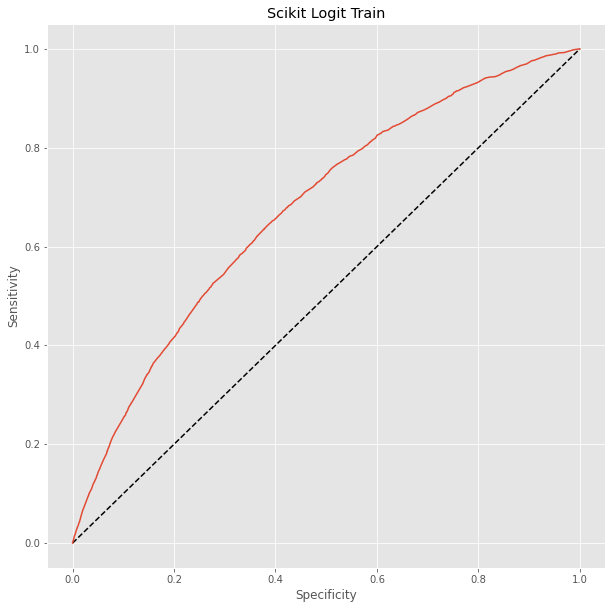

                Model    TP     FP     TN    FN  Sensitivity  Specificity  \
0  Scikit Logit Train  4637  19952  31274  2523     0.647626      0.61051   

   Cutoff  Accuracy       AUC  
0    0.12  0.629068  0.676018  


In [88]:
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
logit_model = LogisticRegression(C=1/reg, max_iter=10000, solver='liblinear').fit(train_x, train_y)

logit_y_scores = logit_model.predict_proba(train_x)
logit_prob = logit_y_scores[:,1]
logit_yhat, logit_stats = get_predict_frame(train_y, logit_prob, 'Scikit Logit Train')
plot_roc(train_y, logit_prob, 'Scikit Logit Train')

print(logit_stats.head())

Sensitivity: 62.500%, Specificity: 61.200%, Threshold: 0.120


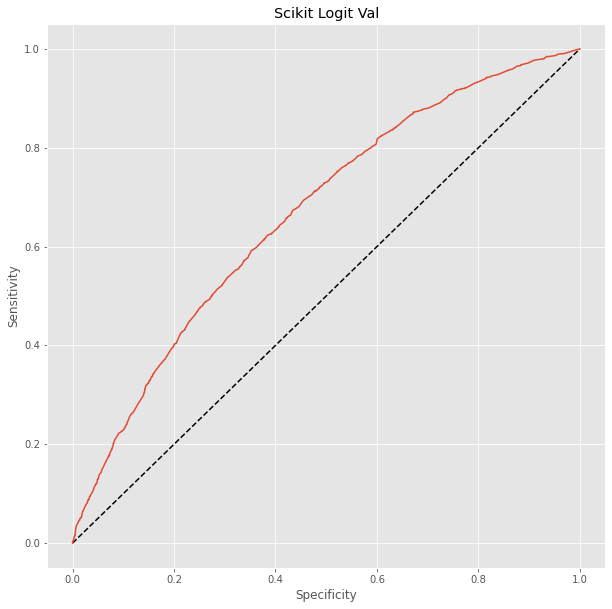

              Model    TP    FP    TN   FN  Sensitivity  Specificity  Cutoff  \
0  Scikit Logit Val  1135  4959  7822  681        0.625     0.612002    0.12   

   Accuracy       AUC  
0  0.618501  0.665933  


In [92]:
logit_y_scores_val = logit_model.predict_proba(val_x)
logit_prob_val = logit_y_scores_val[:,1]
logit_yhat_val, logit_stats_val = get_predict_frame(val_y, logit_prob_val, 'Scikit Logit Val')
plot_roc(val_y, logit_prob_val, 'Scikit Logit Val')

print(logit_stats_val.head())

In [120]:
logit_predictors_df = pd.DataFrame(columns=["X", "Coef"], data=[row for row in zip(sig_features, logit_model.coef_.flatten())])
logit_predictors_df.sort_values(by="Coef", ascending=False, inplace=True)
display(logit_predictors_df)

,X,Coef
18,Make_LEXUS,0.571670
22,Make_SUZUKI,0.562484
19,Make_LINCOLN,0.432195
4,Size_COMPACT,0.420829
16,Make_INFINITI,0.410704
3,Transmission_AUTO,0.364530
12,Make_CHRYSLER,0.284781
1,WheelType_Alloy,0.267569
0,VehicleAge,0.263141
10,Size_SPORTS,0.053154


## Model - Decision Tree

Sensitivity: 70.754%, Specificity: 59.720%, Threshold: 0.120


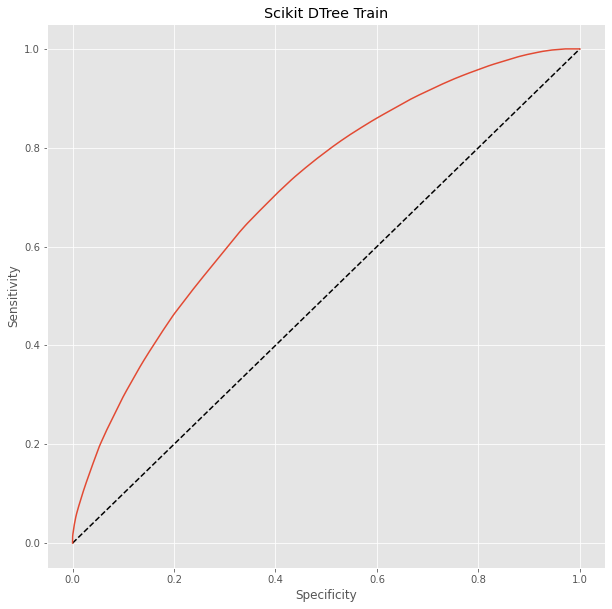

                Model    TP     FP     TN    FN  Sensitivity  Specificity  \
0  Scikit DTree Train  5066  20634  30592  2094     0.707542     0.597197   

   Cutoff  Accuracy       AUC  
0    0.12  0.652369  0.711873  


In [139]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=12, random_state=123).fit(train_x, train_y)

tree_predictions = tree_model.predict(train_x)
tree_y_scores = tree_model.predict_proba(train_x)
tree_prob = tree_y_scores[:,1]
tree_yhat, tree_stats = get_predict_frame(train_y, tree_prob, 'Scikit DTree Train')
plot_roc(train_y, tree_prob, 'Scikit DTree Train')

print(tree_stats.head())

Sensitivity: 66.575%, Specificity: 59.252%, Threshold: 0.120


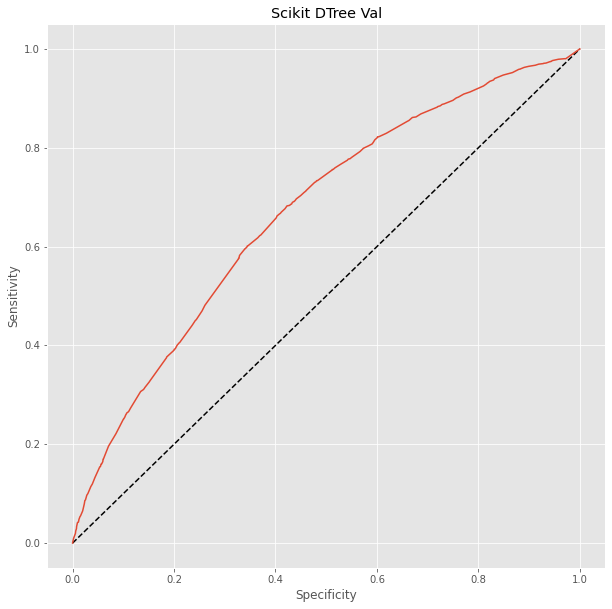

              Model    TP    FP    TN   FN  Sensitivity  Specificity  Cutoff  \
0  Scikit DTree Val  1209  5208  7573  607     0.665749      0.59252    0.12   

   Accuracy      AUC  
0  0.629135  0.66829  


In [140]:
tree_y_scores_val = tree_model.predict_proba(val_x)
tree_prob_val = tree_y_scores_val[:,1]
tree_yhat_val, tree_stats_val = get_predict_frame(val_y, tree_prob_val, 'Scikit DTree Val')
plot_roc(val_y, tree_prob_val, 'Scikit DTree Val')

print(tree_stats_val.head())

In [141]:
dtree_predictors_df = pd.DataFrame(columns=["X", "Importance"], data=[row for row in zip(sig_features, tree_model.feature_importances_.flatten())])
dtree_predictors_df.sort_values(by="Importance", ascending=False, inplace=True)
display(dtree_predictors_df)

,X,Importance
0,VehicleAge,0.415914
1,WheelType_Alloy,0.091278
24,Auction_MANHEIM,0.085733
4,Size_COMPACT,0.059842
3,Transmission_AUTO,0.045059
2,WheelType_Covers,0.038490
11,TopThreeAmericanName_GM,0.033018
12,Make_CHRYSLER,0.027219
22,Make_SUZUKI,0.026801
6,Size_LARGE,0.025870


## Model - Random Forest

Sensitivity: 67.360%, Specificity: 63.335%, Threshold: 0.130


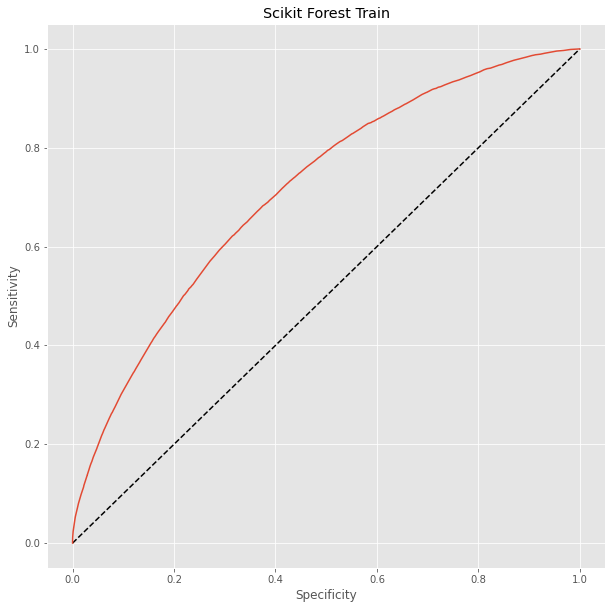

                 Model    TP     FP     TN    FN  Sensitivity  Specificity  \
0  Scikit Forest Train  4823  18782  32444  2337     0.673603      0.63335   

   Cutoff  Accuracy      AUC  
0    0.13  0.653477  0.71398  


In [135]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=123).fit(train_x, train_y)
forest_predictions = forest_model.predict(train_x)
forest_y_scores = forest_model.predict_proba(train_x)
forest_prob = forest_y_scores[:,1]
forest_yhat, forest_stats = get_predict_frame(train_y, forest_prob, 'Scikit Forest Train')
plot_roc(train_y, forest_prob, 'Scikit Forest Train')

print(forest_stats.head())

Sensitivity: 62.941%, Specificity: 63.274%, Threshold: 0.130


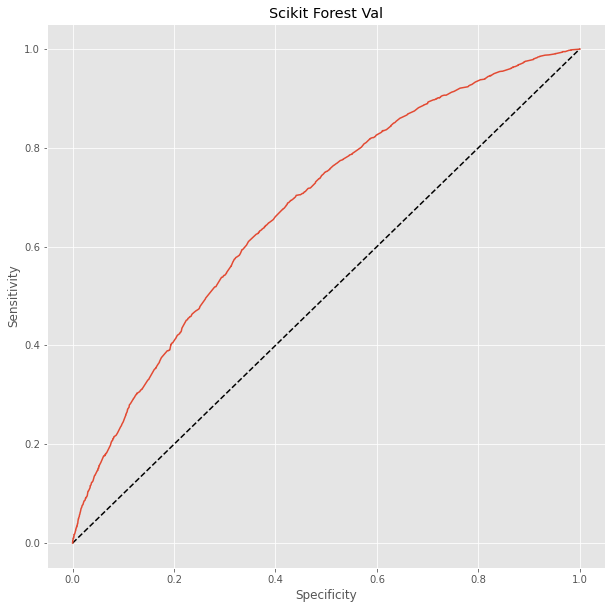

               Model    TP    FP    TN   FN  Sensitivity  Specificity  Cutoff  \
0  Scikit Forest Val  1143  4694  8087  673     0.629405     0.632736    0.13   

   Accuracy       AUC  
0  0.631071  0.677695  


In [136]:
forest_y_scores_val = forest_model.predict_proba(val_x)
forest_prob_val = forest_y_scores_val[:,1]
forest_yhat_val, forest_stats_val = get_predict_frame(val_y, forest_prob_val, 'Scikit Forest Val')
plot_roc(val_y, forest_prob_val, 'Scikit Forest Val')

print(forest_stats_val.head())

In [137]:
forest_predictors_df = pd.DataFrame(columns=["X", "Importance"], data=[row for row in zip(sig_features, tree_model.feature_importances_.flatten())])
forest_predictors_df.sort_values(by="Importance", ascending=False, inplace=True)
display(forest_predictors_df)

,X,Importance
0,VehicleAge,0.499186
1,WheelType_Alloy,0.092065
24,Auction_MANHEIM,0.091508
4,Size_COMPACT,0.061994
2,WheelType_Covers,0.040070
3,Transmission_AUTO,0.031843
22,Make_SUZUKI,0.028012
12,Make_CHRYSLER,0.027360
6,Size_LARGE,0.016932
13,Make_DODGE,0.015101


## Compare Models

In [138]:
schema = {
    'Model': 'object',
    'TP': 'int32',
    'FP': 'int32',
    'TN': 'int32',
    'FP': 'int32',
    'Sensitivity': 'float',
    'Specificity': 'float',
    'Cutoff': 'float',
    'Accuracy': 'float',
    'AUC': 'float'
}
compare = pd.concat([logit_stats_val, tree_stats_val, forest_stats_val], 0)
compare.astype(schema)
compare.sort_values(by='Accuracy', ascending=False, inplace=True)
display(compare)

,Model,TP,FP,TN,FN,Sensitivity,Specificity,Cutoff,Accuracy,AUC
0,Scikit Forest Val,1143,4694,8087,673,0.629405,0.632736,0.13,0.631071,0.677695
0,Scikit DTree Val,1300,5885,6896,516,0.715859,0.539551,0.10,0.627705,0.672166
0,Scikit Logit Val,1135,4959,7822,681,0.625000,0.612002,0.12,0.618501,0.665933


## Results
<p>The best model with a Balanced Accuracy of 0.63 is poor at best and little better than guessing. It would be necessary to supplment the dataset with more predictors.</p>
<p>The common sense type of data that would be theoretically correlated with a "bad buy" include:
<ul>
    <li>Number of previous owners</li>
    <li>Number of accidents/damage</li>
    <li>Blue Book value vs. retail price</li>
    <li>Is drug seizure</li>
    <li>Condition of interior at auction</li>
</ul>
</p>

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:55:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Sensitivity: 73.844%, Specificity: 50.849%, Threshold: 0.170


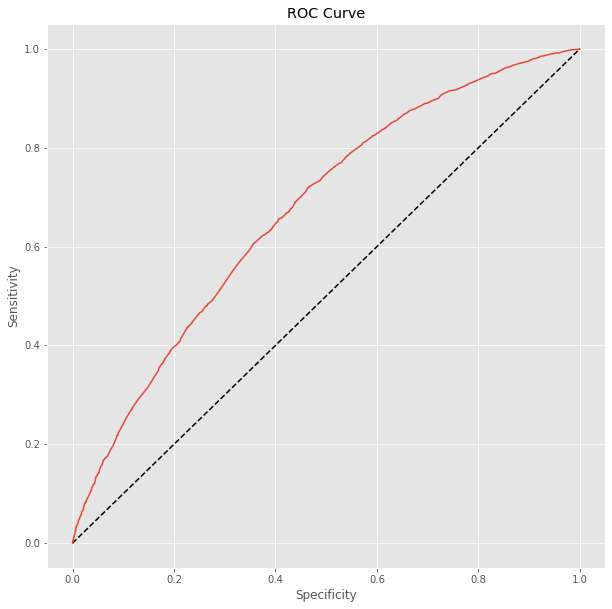

         Model    TP    FP    TN   FN  Sensitivity  Specificity  Cutoff  \
0  XGBoost Val  1341  6282  6499  475     0.738436     0.508489    0.17   

   Accuracy      AUC  
0  0.623463  0.67249  


In [98]:
import shap
from xgboost import XGBRFClassifier

xgboost_model = XGBRFClassifier().fit(train_x, train_y)
xg_predictions = xgboost_model.predict(val_x)
xg_y_scores = xgboost_model.predict_proba(val_x)
xg_prob = xg_y_scores[:,1]
xg_yhat, xg_stats = get_predict_frame(val_y, xg_prob, 'XGBoost Val')
plot_roc(val_y, xg_prob, 'XGBoost Val')
print(xg_stats.head())

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


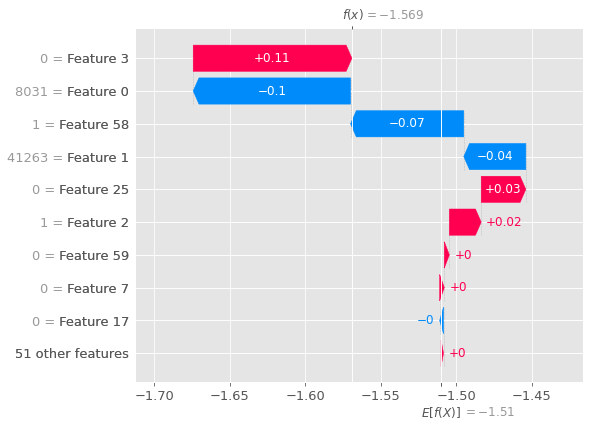

In [41]:
xg_explainer = shap.Explainer(xgboost_model)
xg_shap_values = xg_explainer(val_x)
shap.plots.waterfall(xg_shap_values[0])